## Use new harmonized data file 

From request [Rerun machine learning using the attached spreadsheet.](https://trello.com/c/IoUEsHsC)

## Imports and Function Definitions

In [1]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import itertools

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support, roc_curve, make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split, LeaveOneOut, GridSearchCV, cross_validate
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

def plot_confusion_matrix(cm, classes=[0,1],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def grid_search_optimization(model, tuned_parameters, X, y, Xh, yh, cv=5, scoring='accuracy', verbose=False):
    print("# Tuning hyper-parameters for %s" %scoring)
    print()

    clf = GridSearchCV(model, tuned_parameters, cv=cv, n_jobs = -1, scoring=scoring, verbose=1)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    if verbose:
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

    print("Detailed classification report (holdout):")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = yh, clf.predict(Xh)
    print(classification_report(y_true, y_pred))
    print()
    plot_confusion_matrix(confusion_matrix(y_true, y_pred)) 
    print()
    get_metrics(clf.best_estimator_, Xh, yh)
    
    print("TRAINNG PROBABILITIES")
    for a,b in zip(y, clf.predict_proba(X)[:,1]):
        print(a,b)
    
    return clf

def group_classes(data, grouping):
        classes_to_keep = grouping.keys()
        data_to_keep = data.loc[data['GroupID'].isin(classes_to_keep)]
        classes_to_change = {k:grouping[k] for k in classes_to_keep if k!= grouping[k]}
        return data_to_keep.replace(classes_to_change)
    
def plot_coefficients(classifier, feature_names, top_features=20):
     coef = classifier.coef_.ravel()
     top_positive_coefficients = np.argsort(coef)[-top_features:]
     top_negative_coefficients = np.argsort(coef)[:top_features]
     top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
     # create plot
     plt.figure(figsize=(15, 5))
     colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
     plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
     feature_names = np.array(feature_names)
     plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
     plt.show()
        
def print_feature_importance(feature_names, coefs):
    assert len(feature_names) == len(coefs), "Arrays have difference lengths. Something went wrong"
    for feature, coef in zip(feature_names, coefs):
        print("%s\t%s" %(feature, coef))
        
# AKA True Negative Rate
def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[0,:].sum()

def negative_predictive_value(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[:,0].sum()

def get_weighted_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0,0]
    tp = cm[1,1]
    fp = cm[0,1]
    fn = cm[1,0]
    
    tnw = tn / (tn + fp)
    tpw = tp / (tp + fn)
    fpw = fp / (tn + fp)
    fnw = fn / (tp + fn)
    
    return tpw, fpw, fnw, tnw

def weighted_accuracy(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return (tpw + tnw) / (tpw + fpw + fnw + tnw)
    
def weighted_sensitivity(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)

    return tpw / (tpw + fnw)
    
def weighted_specificity(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)

    return tnw / (tnw + fpw)
    
def weighted_ppv(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return tpw / (tpw + fpw)

def weighted_npv(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return tnw / (tnw + fnw)

def plot_roc(model, X_test, Y_test):
    y_true, y_pred = Y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))

    y_pred_prob = model.predict_proba(X_test)[:,1]

    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)

    print("TESTING PROBABILITIES")
    for a,b in zip(Y_test,y_pred_prob):
        print(a,b)
    
    plt.plot([0,1],[0,1], 'k--')
    plt.plot(fpr, tpr, label='Linear SVC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Linear SVC ROC Curve')
    plt.show()
    
    for a,b in zip(fpr, tpr):
        print(a,b)
    
def get_metrics(model, X, y):
    for metric in _scoring_list:
        score = _scoring_list[metric](model, X, y)
        print("%s\t%s" %(metric, score))

## Define classifier, pipeline and constants

In [2]:
param_grid = {
    "classifier__C": np.logspace(-5, 2, 20),
#     "PCA__n_components": range(1,113,10),
#     "fss__k": range(1,115,3),
},

clf = Pipeline([
#     ('Norm', Normalizer()),\n",
#     ("Oversample", RandomOverSampler()),
#     ('PCA', PCA()),
    ('Scaler', StandardScaler()),
#     ('fss',SelectKBest()),
    ('classifier', SVC(kernel='linear', class_weight='balanced', probability=True))
])

_cv=5
_test_size=0.20
_scoring_list={
    'recall':make_scorer(recall_score),
    'precision':make_scorer(precision_score),
    'auc':make_scorer(roc_auc_score),
    'specificity':make_scorer(specificity),
    'npv':make_scorer(negative_predictive_value),
    'accuracy':make_scorer(accuracy_score),
    'weighted_sensitivity':make_scorer(weighted_sensitivity),
    'weighted_ppv':make_scorer(weighted_ppv),
    'weighted_specificity':make_scorer(weighted_specificity),
    'weighted_npv':make_scorer(weighted_npv),
    'weighted_accuracy':make_scorer(weighted_accuracy)
}

_scoring='f1_micro'
_data = pd.read_excel('Harmonized_Data.xlsx')
_data = _data[['GroupID', 'Age', 'Sex', 'UPDRS']]
_random_seed = 55

## 1. Control vs. PD/MSA/PSP

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:   13.0s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.2s finished


Best parameters set found on development set:

{'classifier__C': 0.26366508987303555}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.84      0.95      0.89        55
          1       0.98      0.93      0.95       146

avg / total       0.94      0.94      0.94       201


Confusion matrix, without normalization
[[ 52   3]
 [ 10 136]]

recall	0.931506849315
precision	0.978417266187
auc	0.938480697385
specificity	0.945454545455
npv	0.838709677419
accuracy	0.935323383085
weighted_sensitivity	0.931506849315
weighted_ppv	0.944683000758
weighted_specificity	0.945454545455
weighted_npv	0.932449029722
weighted_accuracy	0.938480697385
TRAINNG PROBABILITIES
1 0.962326929232
1 0.907275473681
1 0.999999999999
1 0.999999931211
1 0.95097004085
0 0.0955353120497
1 0.996686131199
1 0.999998776254
0 0.0524836858899
0 0.9999998636

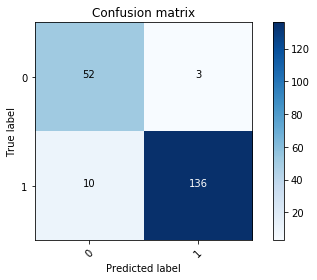

In [3]:
# Get the data
data1 = group_classes(_data, {0:0, 1:1, 2:1, 3:1})

y1 = data1['GroupID']
X1 = data1.drop(['GroupID'], axis=1)

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, y1, test_size=_test_size, random_state=_random_seed)

best1 = grid_search_optimization(clf, param_grid, X_train1, Y_train1, X_test1, Y_test1, cv=_cv, scoring=_scoring)

In [4]:
scores = cross_validate(best1.best_estimator_, X_train1, Y_train1, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.051699924469	0.0249110079516
score_time	0.0535001277924	0.021201368416
test_recall	0.955037481259	0.011417694761
train_recall	0.953287892813	0.00171165005449
test_precision	0.989424603869	0.0101709152522
train_precision	0.989232588946	0.00260014183093
test_auc	0.964033892145	0.0101915633945
train_auc	0.963189047153	0.00365932511898
test_specificity	0.97303030303	0.0263858801629
train_specificity	0.973090201494	0.00654236922719
test_npv	0.894079322638	0.0229887512637
train_npv	0.889350603577	0.00385539204364
test_accuracy	0.96006093988	0.00626441808618
train_accuracy	0.958801596573	0.00253367580328
test_weighted_sensitivity	0.955037481259	0.011417694761
train_weighted_sensitivity	0.953287892813	0.00171165005449
test_weighted_ppv	0.973416891548	0.025499952054
train_weighted_ppv	0.972586111796	0.00652776295255
test_weighted_specificity	0.97303030303	0.0263858801629
train_weighted_specificity	0.973090201494	0.00654236922719
test_weighted_npv	0.956113487075	0.0101957353219
train_

In [5]:
model = best1.best_estimator_.named_steps['classifier']
feature_names = data1.columns.tolist()[1:]
#plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

Age	-0.281583662458
Sex	-0.0727382419415
UPDRS	3.09680969864


             precision    recall  f1-score   support

          0       0.84      0.95      0.89        55
          1       0.98      0.93      0.95       146

avg / total       0.94      0.94      0.94       201

TESTING PROBABILITIES
1 0.999994470402
1 0.999999999998
1 0.999999940159
1 0.830811338242
0 0.0232292157274
0 0.0164923768313
1 0.999983384456
1 0.945964690437
1 1.0
1 0.964661572653
0 0.194080730535
0 0.0653523535073
1 0.99999999999
0 0.280733217306
1 0.999999995612
1 0.999997027312
1 0.204544510438
0 0.0305270701964
1 0.999999978709
1 0.999999969995
1 0.340817936953
1 0.99645111434
1 0.999999988504
0 0.129160422843
0 0.0265721204884
1 1.0
1 0.9962132786
1 0.964800687341
1 0.999999729847
1 0.987055902439
1 0.999999998888
0 0.581843929402
0 0.0652962591633
1 0.999999618032
1 0.999999999971
0 0.605450672395
0 0.0653940338635
1 0.981928263836
1 0.999999999262
1 0.907025649642
1 0.999999989252
1 0.999999709886
0 0.172690827239
1 1.0
1 0.999999999958
0 0.0897572777179
1 0.999999

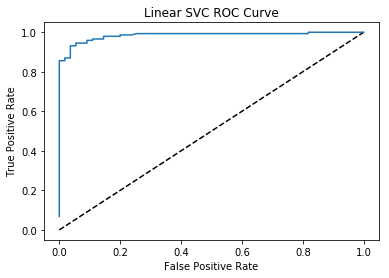

0.0 0.0684931506849
0.0 0.746575342466
0.0 0.760273972603
0.0 0.794520547945
0.0 0.808219178082
0.0 0.856164383562
0.0181818181818 0.856164383562
0.0181818181818 0.869863013699
0.0363636363636 0.869863013699
0.0363636363636 0.876712328767
0.0363636363636 0.890410958904
0.0363636363636 0.931506849315
0.0545454545455 0.931506849315
0.0545454545455 0.945205479452
0.0909090909091 0.945205479452
0.0909090909091 0.958904109589
0.109090909091 0.958904109589
0.109090909091 0.965753424658
0.145454545455 0.965753424658
0.145454545455 0.979452054795
0.163636363636 0.979452054795
0.2 0.979452054795
0.2 0.986301369863
0.236363636364 0.986301369863
0.254545454545 0.993150684932
0.690909090909 0.993150684932
0.727272727273 0.993150684932
0.818181818182 0.993150684932
0.818181818182 1.0
0.854545454545 1.0
0.872727272727 1.0
0.909090909091 1.0
1.0 1.0


In [6]:
plot_roc(best1.best_estimator_, X_test1, Y_test1)

## 2. PD vs MSA/PSP

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.4s finished


Best parameters set found on development set:

{'classifier__C': 0.001623776739188721}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.86      0.69      0.76       105
          1       0.46      0.70      0.55        40

avg / total       0.75      0.69      0.70       145


Confusion matrix, without normalization
[[72 33]
 [12 28]]

recall	0.7
precision	0.459016393443
auc	0.692857142857
specificity	0.685714285714
npv	0.857142857143
accuracy	0.689655172414
weighted_sensitivity	0.7
weighted_ppv	0.69014084507
weighted_specificity	0.685714285714
weighted_npv	0.695652173913
weighted_accuracy	0.692857142857
TRAINNG PROBABILITIES
0 0.401037663944
0 0.363425222041
0 0.314276240588
1 0.423202429027
0 0.359357445894
1 0.200301408302
0 0.32336477197
1 0.558260877052
0 0.200202995354
0 0.337813511688
0 0.293576853295
0 0.2965

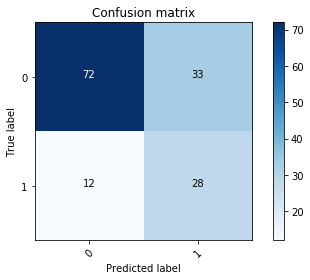

In [7]:
# Get the data
data2 = group_classes(_data, {1:0, 2:1, 3:1})

y2 = data2['GroupID']
X2 = data2.drop(['GroupID'], axis=1)

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, y2, test_size=_test_size, random_state=_random_seed)

best2 = grid_search_optimization(clf, param_grid, X_train2, Y_train2, X_test2, Y_test2, cv=_cv, scoring=_scoring)

In [8]:
scores = cross_validate(best2.best_estimator_, X_train2, Y_train2, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0556994438171	0.015105378365
score_time	0.0418031215668	0.0137866446071
test_recall	0.415462184874	0.0827696539824
train_recall	0.434991137525	0.0951791972632
test_precision	0.55979914822	0.114623740441
train_precision	0.558499233156	0.0432368084781
test_auc	0.633762408306	0.0485129551223
train_auc	0.642682653283	0.0294997057295
test_specificity	0.852062631737	0.0581321538119
train_specificity	0.850374169041	0.0486207952975
test_npv	0.774293966933	0.0261990136601
train_npv	0.780929999103	0.0225407243446
test_accuracy	0.721672240803	0.0448342922331
train_accuracy	0.72622739621	0.0172933541856
test_weighted_sensitivity	0.415462184874	0.0827696539824
train_weighted_sensitivity	0.434991137525	0.0951791972632
test_weighted_ppv	0.74155587167	0.0877654138085
train_weighted_ppv	0.746990511821	0.0322377736029
test_weighted_specificity	0.852062631737	0.0581321538119
train_weighted_specificity	0.850374169041	0.0486207952975
test_weighted_npv	0.594678508402	0.0390421056828
train_weighte

In [9]:
model = best2.best_estimator_.named_steps['classifier']
feature_names = data2.columns.tolist()[1:]
#plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

Age	0.18466683145
Sex	0.0
UPDRS	0.350490239971


             precision    recall  f1-score   support

          0       0.86      0.69      0.76       105
          1       0.46      0.70      0.55        40

avg / total       0.75      0.69      0.70       145

TESTING PROBABILITIES
1 0.301092258279
0 0.163019922195
0 0.191781884901
0 0.288631027771
0 0.327585265115
0 0.831594192501
0 0.308584852251
0 0.184584860084
0 0.153981911028
0 0.207149259633
1 0.478372313695
0 0.202191203632
1 0.393369951267
0 0.308793922369
0 0.181028507307
1 0.385515422642
1 0.315121389987
0 0.63035805531
0 0.262940762433
1 0.301917563351
0 0.466524354695
0 0.309630985718
0 0.192549223538
0 0.511019731856
0 0.206666959512
1 0.511509360845
1 0.759044518834
0 0.365870367413
0 0.701338353946
0 0.236211692971
0 0.229436726158
1 0.336783711857
1 0.52598681376
1 0.288228880844
1 0.449343232982
1 0.454203118293
0 0.331852347864
1 0.661489482965
1 0.575323604871
0 0.196238334134
0 0.362830390458
0 0.26408156938
0 0.239304272293
0 0.242792701245
0 0.171225381211
0

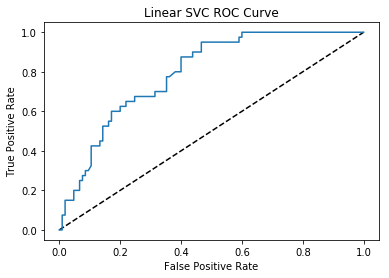

0.0 0.0
0.00952380952381 0.0
0.00952380952381 0.075
0.0190476190476 0.075
0.0190476190476 0.15
0.047619047619 0.15
0.047619047619 0.2
0.0666666666667 0.2
0.0666666666667 0.25
0.0761904761905 0.25
0.0761904761905 0.275
0.0857142857143 0.275
0.0857142857143 0.3
0.0952380952381 0.3
0.104761904762 0.325
0.104761904762 0.425
0.133333333333 0.425
0.133333333333 0.45
0.142857142857 0.45
0.142857142857 0.525
0.161904761905 0.525
0.161904761905 0.55
0.171428571429 0.55
0.171428571429 0.6
0.2 0.6
0.2 0.625
0.219047619048 0.625
0.219047619048 0.65
0.247619047619 0.65
0.247619047619 0.675
0.314285714286 0.675
0.314285714286 0.7
0.352380952381 0.7
0.352380952381 0.775
0.361904761905 0.775
0.380952380952 0.8
0.4 0.8
0.4 0.875
0.438095238095 0.875
0.438095238095 0.9
0.466666666667 0.9
0.466666666667 0.95
0.590476190476 0.95
0.590476190476 0.975
0.6 0.975
0.6 1.0
0.609523809524 1.0
0.628571428571 1.0
0.714285714286 1.0
0.742857142857 1.0
0.895238095238 1.0
0.914285714286 1.0
1.0 1.0


In [10]:
plot_roc(best2.best_estimator_, X_test2, Y_test2)

## 3. MSA vs PD/PSP

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.9s finished


Best parameters set found on development set:

{'classifier__C': 0.001623776739188721}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.96      0.75      0.84       131
          1       0.23      0.71      0.35        14

avg / total       0.89      0.74      0.79       145


Confusion matrix, without normalization
[[98 33]
 [ 4 10]]

recall	0.714285714286
precision	0.232558139535
auc	0.73118865867
specificity	0.748091603053
npv	0.960784313725
accuracy	0.744827586207
weighted_sensitivity	0.714285714286
weighted_ppv	0.73927765237
weighted_specificity	0.748091603053
weighted_npv	0.723628691983
weighted_accuracy	0.73118865867
TRAINNG PROBABILITIES
0 0.123306519192
0 0.100714709709
0 0.112709357426
1 0.178285629871
0 0.116848918654
0 0.0789667815711
0 0.113846353063
1 0.216192350446
0 0.0609369355219
0 0.12582907084
0 0

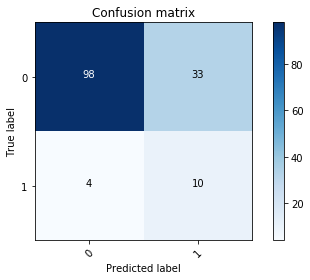

In [11]:
# Get the data
data3 = group_classes(_data, {1:0, 3:0, 2:1})

y3 = data3['GroupID']
X3 = data3.drop(['GroupID'], axis=1)

X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3, y3, test_size=_test_size, random_state=_random_seed)

best3 = grid_search_optimization(clf, param_grid, X_train3, Y_train3, X_test3, Y_test3, cv=_cv, scoring=_scoring)

In [12]:
scores = cross_validate(best3.best_estimator_, X_train3, Y_train3, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0865020275116	0.0181197734634
score_time	0.0495949268341	0.00917893744879
test_recall	0.485714285714	0.227676820722
train_recall	0.528571428571	0.0834522960396
test_precision	0.314704136443	0.12433091285
train_precision	0.350062253713	0.0463560024552
test_auc	0.671113792051	0.121546568361
train_auc	0.694539965863	0.0296313097041
test_specificity	0.856513298389	0.0335165926824
train_specificity	0.860508503156	0.0418022679207
test_npv	0.924208023519	0.0328923795821
train_npv	0.930320392442	0.00969430717994
test_accuracy	0.811649175412	0.0478221530249
train_accuracy	0.82037592165	0.0299936685473
test_weighted_sensitivity	0.485714285714	0.227676820722
train_weighted_sensitivity	0.528571428571	0.0834522960396
test_weighted_ppv	0.742881893844	0.103943636726
train_weighted_ppv	0.79353019494	0.0338047473521
test_weighted_specificity	0.856513298389	0.0335165926824
train_weighted_specificity	0.860508503156	0.0418022679207
test_weighted_npv	0.643858033427	0.124327961528
train_weighted_

In [13]:
model = best3.best_estimator_.named_steps['classifier']
feature_names = data3.columns.tolist()[1:]
#plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

Age	0.0130610609243
Sex	0.0
UPDRS	0.448169153567


             precision    recall  f1-score   support

          0       0.96      0.75      0.84       131
          1       0.23      0.71      0.35        14

avg / total       0.89      0.74      0.79       145

TESTING PROBABILITIES
1 0.103710084796
0 0.0623798683036
0 0.0604819987729
0 0.0903177922781
0 0.127181105248
0 0.437051103579
0 0.0958211190966
0 0.0876789586379
0 0.0676077362524
0 0.059882559536
0 0.193775690732
0 0.0589596210933
1 0.160458274458
0 0.0932620644708
0 0.062617914035
1 0.196056909752
0 0.101292619504
0 0.229359876654
0 0.0873132961057
0 0.0931092604566
0 0.159905373328
0 0.0836295512718
0 0.0798612810601
0 0.190259733219
0 0.0651355022644
0 0.18121833556
0 0.395223494858
0 0.12662684461
0 0.405445498846
0 0.104219855634
0 0.092616685423
1 0.143211081407
0 0.21496919543
0 0.0953521415931
0 0.139249250943
1 0.192929596081
0 0.113071543422
1 0.329945494953
1 0.197188241395
0 0.0649156250813
0 0.180557288387
0 0.0740372670803
0 0.0777221147119
0 0.0861303547122


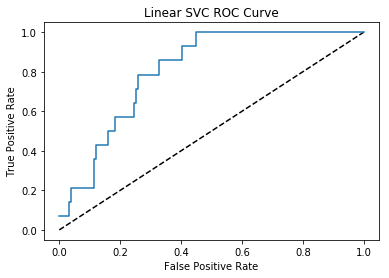

0.0 0.0714285714286
0.030534351145 0.0714285714286
0.030534351145 0.142857142857
0.0381679389313 0.142857142857
0.0381679389313 0.214285714286
0.114503816794 0.214285714286
0.114503816794 0.357142857143
0.12213740458 0.357142857143
0.12213740458 0.428571428571
0.160305343511 0.428571428571
0.160305343511 0.5
0.18320610687 0.5
0.18320610687 0.571428571429
0.24427480916 0.571428571429
0.24427480916 0.642857142857
0.251908396947 0.642857142857
0.251908396947 0.714285714286
0.259541984733 0.714285714286
0.259541984733 0.785714285714
0.328244274809 0.785714285714
0.328244274809 0.857142857143
0.404580152672 0.857142857143
0.404580152672 0.928571428571
0.450381679389 0.928571428571
0.450381679389 1.0
0.458015267176 1.0
0.480916030534 1.0
0.580152671756 1.0
0.595419847328 1.0
0.770992366412 1.0
0.786259541985 1.0
0.81679389313 1.0
0.839694656489 1.0
1.0 1.0


In [14]:
plot_roc(best3.best_estimator_, X_test3, Y_test3)

## 4. PSP vs PD/MSA

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.6s finished


Best parameters set found on development set:

{'classifier__C': 0.001623776739188721}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.91      0.72      0.81       119
          1       0.35      0.69      0.47        26

avg / total       0.81      0.72      0.75       145


Confusion matrix, without normalization
[[86 33]
 [ 8 18]]

recall	0.692307692308
precision	0.352941176471
auc	0.707498383969
specificity	0.72268907563
npv	0.914893617021
accuracy	0.71724137931
weighted_sensitivity	0.692307692308
weighted_ppv	0.714
weighted_specificity	0.72268907563
weighted_npv	0.701380175659
weighted_accuracy	0.707498383969
TRAINNG PROBABILITIES
0 0.180663787699
0 0.1804761062
0 0.168967880922
0 0.172501045271
0 0.175212897811
1 0.157066963221
0 0.170237026645
0 0.187228179528
0 0.164047548352
0 0.169177050807
0 0.17278785481

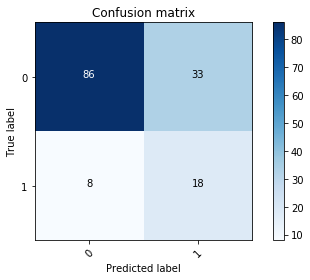

In [15]:
# Get the data
data4 = group_classes(_data, {1:0, 2:0, 3:1})

y4 = data4['GroupID']
X4 = data4.drop(['GroupID'], axis=1)

X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X4, y4, test_size=_test_size, random_state=_random_seed)

best4 = grid_search_optimization(clf, param_grid, X_train4, Y_train4, X_test4, Y_test4, cv=_cv, scoring=_scoring)

In [16]:
scores = cross_validate(best4.best_estimator_, X_train4, Y_train4, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0706023693085	0.00281710380663
score_time	0.0476973056793	0.0208150069384
test_recall	0.521428571429	0.260210973187
train_recall	0.495503967088	0.23386648139
test_precision	0.270787037037	0.0733004158257
train_precision	0.263500748128	0.0365958572875
test_auc	0.594573934837	0.0540239443827
train_auc	0.581298744146	0.0213205045462
test_specificity	0.667719298246	0.231120226162
train_specificity	0.667093521205	0.243351043347
test_npv	0.88730980693	0.0599350470096
train_npv	0.873080956027	0.0369319223025
test_accuracy	0.642422122272	0.148164387603
train_accuracy	0.636410252876	0.159478933407
test_weighted_sensitivity	0.521428571429	0.260210973187
train_weighted_sensitivity	0.495503967088	0.23386648139
test_weighted_ppv	0.621565137622	0.0773789463358
train_weighted_ppv	0.619966341659	0.0463608971125
test_weighted_specificity	0.667719298246	0.231120226162
train_weighted_specificity	0.667093521205	0.243351043347
test_weighted_npv	0.65605875575	0.177206377038
train_weighted_npv	0.6

In [17]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
#plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

Age	0.25740126977
Sex	0.0
UPDRS	0.148589604098


             precision    recall  f1-score   support

          0       0.91      0.72      0.81       119
          1       0.35      0.69      0.47        26

avg / total       0.81      0.72      0.75       145

TESTING PROBABILITIES
0 0.169101748236
0 0.154497807899
0 0.16347904908
0 0.170883330053
0 0.167032295612
0 0.214348016161
0 0.172756345231
0 0.15079238593
0 0.150099679352
0 0.166093968098
1 0.178350490794
0 0.166564730725
0 0.171111208424
0 0.173592104242
0 0.15884066617
0 0.163521235116
1 0.172271700698
0 0.196978571546
0 0.167053067261
1 0.172407642429
0 0.18291927026
0 0.176967085247
0 0.155047080761
0 0.184130319672
0 0.163682762645
1 0.185890509624
1 0.200105945779
0 0.173882760145
0 0.186666766032
0 0.156947102154
0 0.158853347232
0 0.16511447724
1 0.182240987646
1 0.169235700008
1 0.184703701243
0 0.174739924573
0 0.171305642538
0 0.188883251686
0 0.193376660588
0 0.161428761972
0 0.162455198675
0 0.171983177097
0 0.165698334418
0 0.163525427809
0 0.152101259737
0 0

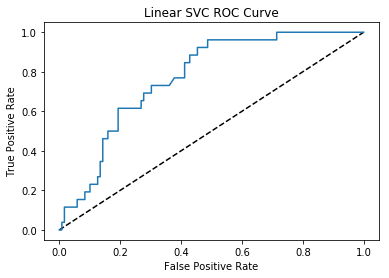

0.0 0.0
0.00840336134454 0.0
0.00840336134454 0.0384615384615
0.0168067226891 0.0384615384615
0.0168067226891 0.115384615385
0.0588235294118 0.115384615385
0.0588235294118 0.153846153846
0.0840336134454 0.153846153846
0.0840336134454 0.192307692308
0.100840336134 0.192307692308
0.100840336134 0.230769230769
0.126050420168 0.230769230769
0.126050420168 0.269230769231
0.134453781513 0.269230769231
0.134453781513 0.346153846154
0.142857142857 0.346153846154
0.142857142857 0.461538461538
0.159663865546 0.461538461538
0.159663865546 0.5
0.193277310924 0.5
0.193277310924 0.615384615385
0.268907563025 0.615384615385
0.268907563025 0.653846153846
0.27731092437 0.653846153846
0.27731092437 0.692307692308
0.302521008403 0.692307692308
0.302521008403 0.730769230769
0.361344537815 0.730769230769
0.378151260504 0.769230769231
0.411764705882 0.769230769231
0.411764705882 0.846153846154
0.428571428571 0.846153846154
0.428571428571 0.884615384615
0.453781512605 0.884615384615
0.453781512605 0.92307692

In [18]:
plot_roc(best4.best_estimator_, X_test4, Y_test4)

## 5. PSP (positive) vs MSA (negative)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.5s finished


Best parameters set found on development set:

{'classifier__C': 0.048329302385717518}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.31      0.38      0.34        13
          1       0.70      0.63      0.67        30

avg / total       0.59      0.56      0.57        43


Confusion matrix, without normalization
[[ 5  8]
 [11 19]]

recall	0.633333333333
precision	0.703703703704
auc	0.508974358974
specificity	0.384615384615
npv	0.3125
accuracy	0.558139534884
weighted_sensitivity	0.633333333333
weighted_ppv	0.507186858316
weighted_specificity	0.384615384615
weighted_npv	0.511945392491
weighted_accuracy	0.508974358974
TRAINNG PROBABILITIES
1 0.47965123073
0 0.582374673535
0 0.0810274793853
1 0.924348945671
1 0.296951077078
1 0.874441660639
1 0.871987362035
0 0.441262716315
1 0.928758387416
1 0.710162076491
1 0.93367

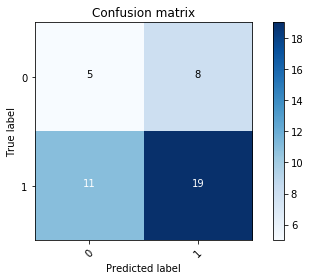

In [19]:
# Get the data
data5 = group_classes(_data, {2:0, 3:1})

y5 = data5['GroupID']
X5 = data5.drop(['GroupID'], axis=1)

X_train5, X_test5, Y_train5, Y_test5 = train_test_split(X5, y5, test_size=_test_size, random_state=_random_seed)

best5 = grid_search_optimization(clf, param_grid, X_train5, Y_train5, X_test5, Y_test5, cv=_cv, scoring=_scoring)

In [20]:
scores = cross_validate(best5.best_estimator_, X_train5, Y_train5, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0154013156891	0.0115872546899
score_time	0.0180985450745	0.00491378230617
test_recall	0.667894736842	0.105215778811
train_recall	0.676803797468	0.0228873396369
test_precision	0.781764507422	0.0957109683723
train_precision	0.782399129074	0.0346019059782
test_auc	0.699661654135	0.0901241911717
train_auc	0.706290369912	0.0301353128205
test_specificity	0.731428571429	0.124343172269
train_specificity	0.735776942356	0.0491779203385
test_npv	0.616666666667	0.104436724759
train_npv	0.619871740064	0.0277935226111
test_accuracy	0.693868092692	0.0887190398129
train_accuracy	0.701463591114	0.0277940644804
test_weighted_sensitivity	0.667894736842	0.105215778811
train_weighted_sensitivity	0.676803797468	0.0228873396369
test_weighted_ppv	0.723503060295	0.116868020371
train_weighted_ppv	0.720987818774	0.042248042129
test_weighted_specificity	0.731428571429	0.124343172269
train_weighted_specificity	0.735776942356	0.0491779203385
test_weighted_npv	0.689550608599	0.0890769851567
train_weighted

In [21]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
#plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

Age	0.25740126977
Sex	0.0
UPDRS	0.148589604098


             precision    recall  f1-score   support

          0       0.31      0.38      0.34        13
          1       0.70      0.63      0.67        30

avg / total       0.59      0.56      0.57        43

TESTING PROBABILITIES
0 0.338246084125
1 0.852019867987
1 0.323443433648
0 0.731946302594
0 0.640006898206
1 0.65963821351
0 0.528536565135
0 0.666662380642
1 0.5
1 0.699177151657
1 0.562146075705
1 0.207417933269
1 0.478194069434
0 0.881809073186
0 0.644927974996
1 0.728501200452
1 0.632097125937
1 0.782101486853
1 0.805920921571
1 0.370145704178
0 0.625284407426
1 0.680829240878
1 0.412079064696
0 0.774116382773
1 0.91213223271
1 0.694255496727
1 0.83265828088
1 0.434998574143
1 0.839589210837
1 0.754607271182
1 0.313203786789
0 0.188026567542
1 0.67387267892
0 0.313075631311
1 0.411942601312
0 0.273917150781
1 0.854940990912
1 0.590844428508
1 0.645198123189
1 0.666748237558
0 0.719583066101
1 0.675485493559
1 0.402002792937


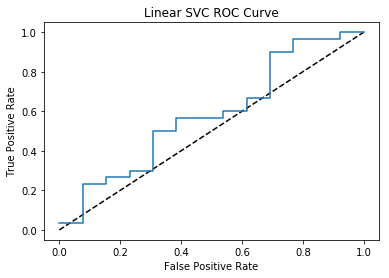

0.0 0.0333333333333
0.0769230769231 0.0333333333333
0.0769230769231 0.233333333333
0.153846153846 0.233333333333
0.153846153846 0.266666666667
0.230769230769 0.266666666667
0.230769230769 0.3
0.307692307692 0.3
0.307692307692 0.5
0.384615384615 0.5
0.384615384615 0.566666666667
0.538461538462 0.566666666667
0.538461538462 0.6
0.615384615385 0.6
0.615384615385 0.666666666667
0.692307692308 0.666666666667
0.692307692308 0.9
0.769230769231 0.9
0.769230769231 0.966666666667
0.923076923077 0.966666666667
0.923076923077 1.0
1.0 1.0


In [22]:
plot_roc(best5.best_estimator_, X_test5, Y_test5)

## 6. MSA (positive) vs PSP (negative)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:   10.8s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.3s finished


Best parameters set found on development set:

{'classifier__C': 0.048329302385717518}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.70      0.63      0.67        30
          1       0.31      0.38      0.34        13

avg / total       0.59      0.56      0.57        43


Confusion matrix, without normalization
[[19 11]
 [ 8  5]]

recall	0.384615384615
precision	0.3125
auc	0.508974358974
specificity	0.633333333333
npv	0.703703703704
accuracy	0.558139534884
weighted_sensitivity	0.384615384615
weighted_ppv	0.511945392491
weighted_specificity	0.633333333333
weighted_npv	0.507186858316
weighted_accuracy	0.508974358974
TRAINNG PROBABILITIES
0 0.522125063641
1 0.427499079305
1 0.90559423155
0 0.0909238363165
0 0.69228594601
0 0.144237117765
0 0.14675073338
1 0.557896740606
0 0.08621437596
0 0.306312490112
0 0.08078070

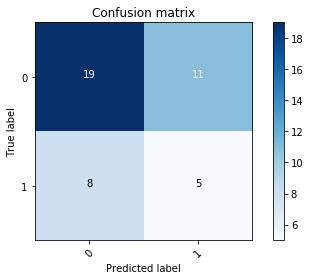

In [23]:
# Get the data
data6 = group_classes(_data, {2:1, 3:0})

y6 = data6['GroupID']
X6 = data6.drop(['GroupID'], axis=1)

X_train6, X_test6, Y_train6, Y_test6 = train_test_split(X6, y6, test_size=_test_size, random_state=_random_seed)

best6 = grid_search_optimization(clf, param_grid, X_train6, Y_train6, X_test6, Y_test6, cv=_cv, scoring=_scoring)

In [24]:
scores = cross_validate(best4.best_estimator_, X_train6, Y_train6, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:156: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:156: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being 

fit_time	0.00900330543518	0.00418700107288
score_time	0.0225982666016	0.0120251319783
test_recall	0.2	0.4
train_recall	0.2	0.4
test_precision	0.0848484848485	0.169696969697
train_precision	0.0832116788321	0.166423357664
test_auc	0.5	0.0
train_auc	0.5	0.0
test_specificity	0.8	0.4
train_specificity	0.8	0.4
test_npv	nan	nan
train_npv	nan	nan
test_accuracy	0.552075375605	0.064247068047
train_accuracy	0.548778127634	0.0663807883962
test_weighted_sensitivity	0.2	0.4
train_weighted_sensitivity	0.2	0.4
test_weighted_ppv	nan	nan
train_weighted_ppv	nan	nan
test_weighted_specificity	0.8	0.4
train_weighted_specificity	0.8	0.4
test_weighted_npv	nan	nan
train_weighted_npv	nan	nan
test_weighted_accuracy	0.5	0.0
train_weighted_accuracy	0.5	0.0


In [25]:
model = best6.best_estimator_.named_steps['classifier']
feature_names = data6.columns.tolist()[1:]
#plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

Age	-0.591393122754
Sex	-0.18840053372
UPDRS	0.661648238171


             precision    recall  f1-score   support

          0       0.70      0.63      0.67        30
          1       0.31      0.38      0.34        13

avg / total       0.59      0.56      0.57        43

TESTING PROBABILITIES
1 0.656316635567
0 0.167262865666
0 0.666694160387
1 0.285311614216
1 0.37674735176
0 0.3567069505
1 0.476810044931
1 0.350418173445
0 0.507765516005
0 0.317212786496
0 0.445920448936
0 0.777806460547
0 0.523623016478
1 0.136525382916
1 0.369610531997
0 0.288731399347
0 0.383344054255
0 0.237105079857
0 0.213566018705
0 0.627055042
1 0.389654916988
0 0.337132173348
0 0.585512267517
1 0.244577478354
0 0.104180739858
0 0.321869920986
0 0.186911413384
0 0.563596107784
0 0.179539180989
0 0.263518715313
0 0.676464661017
1 0.796893732975
0 0.34385828474
1 0.676690418352
0 0.585554123324
1 0.714060248766
0 0.164241510542
0 0.419556074553
0 0.369245501552
0 0.349807985996
1 0.297697212879
0 0.342092080145
0 0.595317030238


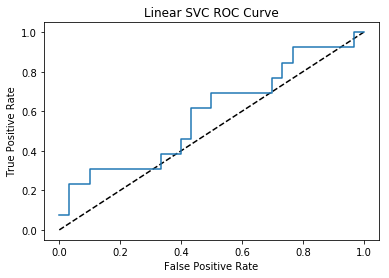

0.0 0.0769230769231
0.0333333333333 0.0769230769231
0.0333333333333 0.230769230769
0.1 0.230769230769
0.1 0.307692307692
0.333333333333 0.307692307692
0.333333333333 0.384615384615
0.4 0.384615384615
0.4 0.461538461538
0.433333333333 0.461538461538
0.433333333333 0.615384615385
0.5 0.615384615385
0.5 0.692307692308
0.7 0.692307692308
0.7 0.769230769231
0.733333333333 0.769230769231
0.733333333333 0.846153846154
0.766666666667 0.846153846154
0.766666666667 0.923076923077
0.966666666667 0.923076923077
0.966666666667 1.0
1.0 1.0


In [26]:
plot_roc(best6.best_estimator_, X_test6, Y_test6)

In [27]:
print("Control (0) vs All Parkinsons(1)")
print("TRAIN/VALIDATION")
print(Y_train1.value_counts())
print("TEST")
print(Y_test1.value_counts())
print()
print("=====================================")
print()
print("2. PD(0) vs MSA/PSP(1)")
print("TRAIN/VALIDATION")
print(Y_train2.value_counts())
print("TEST")
print(Y_test2.value_counts())
print()
print("=====================================")
print()
print("MSA (0) vs PD/PSP(1)")
print("TRAIN/VALIDATION")
print(Y_train3.value_counts())
print("TEST")
print(Y_test3.value_counts())
print()
print("=====================================")
print()
print("PSP (0) vs MSA/PD (1)")
print("TRAIN/VALIDATION")
print(Y_train4.value_counts())
print("TEST")
print(Y_test4.value_counts())
print("=====================================")
print()
print("MSA (0) vs PSP(1)")
print("TRAIN/VALIDATION")
print(Y_train5.value_counts())
print("TEST")
print(Y_test5.value_counts())
print()
print("=====================================")
print()
print("PSP (0) vs MSA(1)")
print("TRAIN/VALIDATION")
print(Y_train6.value_counts())
print("TEST")
print(Y_test6.value_counts())
print()


Control (0) vs All Parkinsons(1)
TRAIN/VALIDATION
1    578
0    223
Name: GroupID, dtype: int64
TEST
1    146
0     55
Name: GroupID, dtype: int64


2. PD(0) vs MSA/PSP(1)
TRAIN/VALIDATION
0    406
1    173
Name: GroupID, dtype: int64
TEST
0    105
1     40
Name: GroupID, dtype: int64


MSA (0) vs PD/PSP(1)
TRAIN/VALIDATION
0    509
1     70
Name: GroupID, dtype: int64
TEST
0    131
1     14
Name: GroupID, dtype: int64


PSP (0) vs MSA/PD (1)
TRAIN/VALIDATION
0    476
1    103
Name: GroupID, dtype: int64
TEST
0    119
1     26
Name: GroupID, dtype: int64

MSA (0) vs PSP(1)
TRAIN/VALIDATION
1    99
0    71
Name: GroupID, dtype: int64
TEST
1    30
0    13
Name: GroupID, dtype: int64


PSP (0) vs MSA(1)
TRAIN/VALIDATION
0    99
1    71
Name: GroupID, dtype: int64
TEST
0    30
1    13
Name: GroupID, dtype: int64



In [28]:
import pickle
mod_name = 'updrs-plus'
pickle.dump(best1, open('./models/%s/park_v_control.pkl' %mod_name, 'wb'))
pickle.dump(best2, open('./models/%s/pd_v_atypical.pkl' %mod_name, 'wb'))
pickle.dump(best3, open('./models/%s/msa_v_pd_psp.pkl' %mod_name, 'wb'))
pickle.dump(best4, open('./models/%s/psp_v_pd_msa.pkl' %mod_name, 'wb'))
pickle.dump(best5, open('./models/%s/psp_v_msa.pkl' %mod_name, 'wb'))